# Odczyt i podział danych

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

def read_data(file_path):
    data = pd.read_csv(file_path, sep='\t', names=['label', 'message'])
    data['message'] = data['message'].str.replace('[^\w\s]', '', regex=True)
    return data

# To nie jest implementacja klasyfikatora z zewnetrznej biblioteki tylko ngramu
# vectorizer - obiekt do transformacji tekstu do formatu n-gramów
# X - macierz n-gramów , w ktorej wiersze odpowiadaja wiadomosciom, a kolumny n-gramom
def create_n_grams(df, n):
    vectorizer = CountVectorizer(ngram_range=(1, n))
    X = vectorizer.fit_transform(df['message'])
    return vectorizer, X

df = read_data('SMSSpamCollection')
print(df.head(10))

vectorizer, X = create_n_grams(df, 3)
print(vectorizer.get_feature_names_out())

train, test = train_test_split(df, test_size=0.3, random_state=42)

  label                                            message
0   ham  Go until jurong point crazy Available only in ...
1   ham                            Ok lar Joking wif u oni
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham        U dun say so early hor U c already then say
4   ham  Nah I dont think he goes to usf he lives aroun...
5  spam  FreeMsg Hey there darling its been 3 weeks now...
6   ham  Even my brother is not like to speak with me T...
7   ham  As per your request Melle Melle Oru Minnaminun...
8  spam  WINNER As a valued network customer you have b...
9  spam  Had your mobile 11 months or more U R entitled...
['008704050406' '008704050406 sp' '008704050406 sp arrow' ...
 'üll finish buying' 'üll take' 'üll take forever']


# Klasyfikator oparty na algorytmie MNB z ngramami

In [15]:
class MultinomialNaiveBayes:
    def __init__(self, n, a=1):
        self.class_probabilities = {}
        self.conditional_probabilities = {}
        self.n = n
        self.a = a

    def train(self, df):
        self.class_probabilities['spam'] = sum(df['label'] == 'spam') / len(df)
        self.class_probabilities['ham'] = sum(df['label'] == 'ham') / len(df)

        self.vectorizer, X = create_n_grams(df, self.n)
        feature_names = self.vectorizer.get_feature_names_out()
        m = len(feature_names)
        # Konwersja X na 1 wymiarowa tablice i sprawdzenie ile razy dany token wystepuje w spamie i hamie
        N_c_spam = sum(X[df['label'] == 'spam'].toarray().ravel())
        N_c_ham = sum(X[df['label'] == 'ham'].toarray().ravel())

        for token in feature_names:
            token_index = np.where(feature_names == token)[0][0]
            N_tc_spam = X[df['label'] == 'spam', token_index].sum()
            N_tc_ham = X[df['label'] == 'ham', token_index].sum()

            self.conditional_probabilities[token] = {
                'spam': (self.a + N_tc_spam) / (self.a * m + N_c_spam),
                'ham': (self.a + N_tc_ham) / (self.a * m + N_c_ham)
            }

    def predict(self, message):
        X = self.vectorizer.transform([message])
        feature_names = self.vectorizer.get_feature_names_out()

        spam_probability = np.log(self.class_probabilities['spam'])
        ham_probability = np.log(self.class_probabilities['ham'])

        for token_index in X.indices:
            token = feature_names[token_index]
            if token in self.conditional_probabilities:
                spam_probability += np.log(self.conditional_probabilities[token]['spam'])
                ham_probability += np.log(self.conditional_probabilities[token]['ham'])

        if spam_probability > ham_probability:
            return 'spam'
        else:
            return 'ham'

nb = MultinomialNaiveBayes(3,1.0)
nb.train(train)

# Testowanie przy użyciu metryk precision i recall, f1-score oraz accuracy

Precision : fraction of relevant instances among retieved instances

            Relevant retrieved instances / All retrieved instances
            True positive / True positive + false positive   -> Obrazek na wiki to lepiej tlumaczy niz ich definicja
            Spam zaklasyfikowany jako spam / ---;--- + ham zaklasyfikowany jako spam
- Chlopski rozum: jak bardzo precyzyjnie odrozniamy spam od hamu (a nie że wszystko jako spam i fajrant)

Recall    : fraction of relevant instances that were retrieved

            Relevant retrieved instances / All relevant instances
            True positive / True positive + false negative
            Spam zaklasyfikowany jako spam / ---;--- + spam zaklasyfikowany jako ham
- Chlopski rozum: czyli po prostu jak dobrze rozpoznaje spam (brak analogii na recall)

F1      : 

            ogolna miara poprawnosci uwzgledniajaca precision i recall opisana wzorem
            F1 = 2 * (precision * recall) / (precision + recall)

Accuracy :  

         najbardziej intuicyjny sposób rozpoznawania 
         mozna opisac wzorem TP + TN/ (TP + TN + FP + FN)
         albo po prostu: poprawne klasyfikacje / wszystkie klasyfikacje

In [16]:
print(len(test))
def precision(nb, test_df):
    y_true = test_df['label']
    y_pred = test_df['message'].apply(nb.predict)
    tp = sum((y_true == 'spam') & (y_pred == 'spam'))
    fp = sum((y_true == 'ham') & (y_pred == 'spam'))
    return tp / (tp + fp)

def recall(nb, test_df):
    y_true = test_df['label']
    y_pred = test_df['message'].apply(nb.predict)
    tp = sum((y_true == 'spam') & (y_pred == 'spam'))
    fn = sum((y_true == 'spam') & (y_pred == 'ham'))
    return tp / (tp + fn)

def f1_score(nb, test_df):
    p = precision(nb, test_df)
    r = recall(nb, test_df)
    return 2 * p * r / (p + r)

def accuracy(nb, test_df):
    y_true = test_df['label']
    y_pred = test_df['message'].apply(nb.predict)
    return sum(y_true == y_pred) / len(y_true)

# Usage
print(f'Precision: {precision(nb, test)}')
print(f'Recall: {recall(nb, test)}')
print(f'F1 score: {f1_score(nb, test)}')
print(f'Accuracy: {accuracy(nb, test)}')

1672
Precision: 1.0
Recall: 0.8973214285714286
F1 score: 0.9458823529411765
Accuracy: 0.986244019138756


# Wykresy

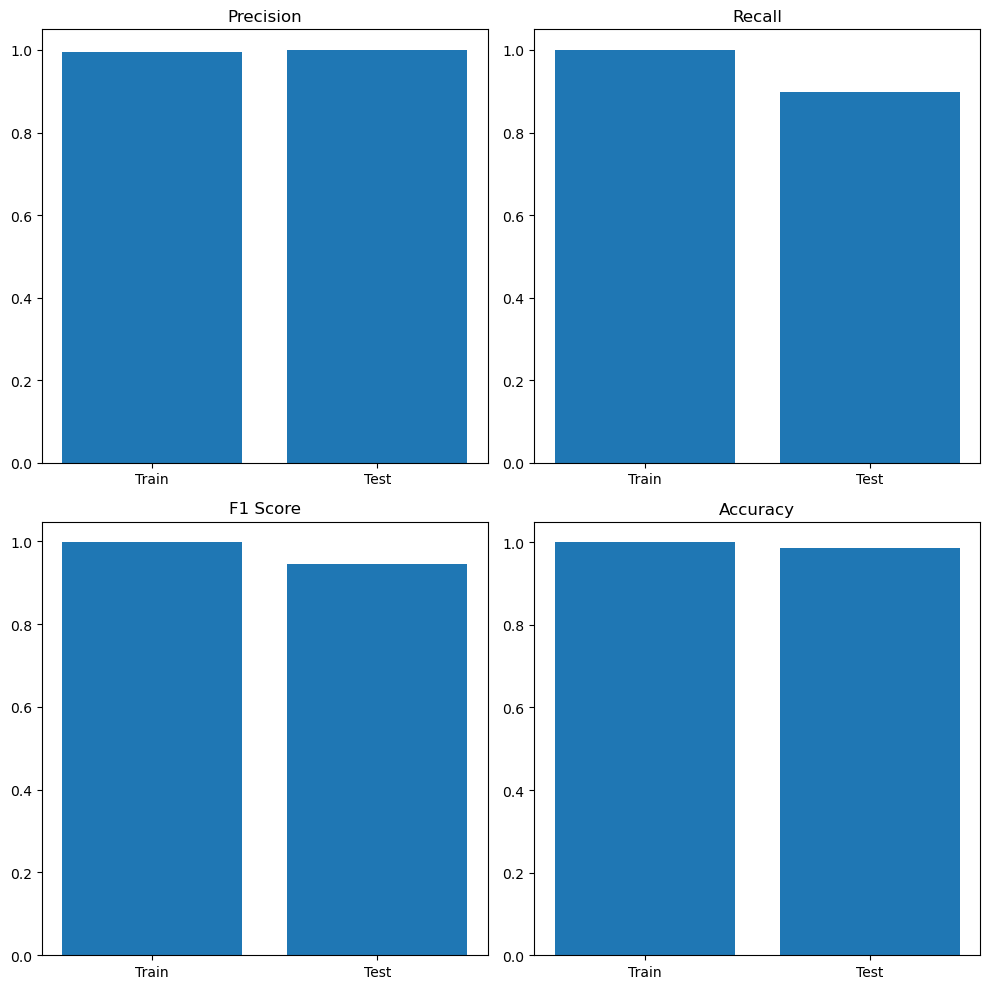

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(nb, train_df, test_df):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Precision
    axs[0, 0].bar(['Train', 'Test'], [precision(nb, train_df), precision(nb, test_df)])
    axs[0, 0].set_title('Precision')

    # Recall
    axs[0, 1].bar(['Train', 'Test'], [recall(nb, train_df), recall(nb, test_df)])
    axs[0, 1].set_title('Recall')

    # F1 score
    axs[1, 0].bar(['Train', 'Test'], [f1_score(nb, train_df), f1_score(nb, test_df)])
    axs[1, 0].set_title('F1 Score')

    # Accuracy
    axs[1, 1].bar(['Train', 'Test'], [accuracy(nb, train_df), accuracy(nb, test_df)])
    axs[1, 1].set_title('Accuracy')

    plt.tight_layout()
    plt.show()


plot_metrics(nb, train, test)